In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class_map = {
    "ductal_carcinoma": 0,
    "lobular_carcinoma": 1,
    "mucinous_carcinoma": 2,
    "papillary_carcinoma": 3
}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
])

class BreakHisMalignant40X(Dataset):
    def __init__(self, root_dir, class_map, transform=None):
        self.samples = []
        self.transform = transform

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path): continue

            for sob_folder in os.listdir(class_path):
                sob_path = os.path.join(class_path, sob_folder, "200X")
                if not os.path.isdir(sob_path): continue

                for img_name in os.listdir(sob_path):
                    img_path = os.path.join(sob_path, img_name)
                    self.samples.append((img_path, class_map[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



In [4]:
root_dir = r"E:\cancer_dl\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant\SOB"
dataset = BreakHisMalignant40X(root_dir, class_map, transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [6]:
print(f"Total dataset size: {len(dataset)}")
print(f"Training set: {len(train_set)} samples ({len(train_set) / len(dataset) * 100:.1f}%)")
print(f"Validation set: {len(val_set)} samples ({len(val_set) / len(dataset) * 100:.1f}%)")
print(f"Test set: {len(test_set)} samples ({len(test_set) / len(dataset) * 100:.1f}%)")

Total dataset size: 1390
Training set: 972 samples (69.9%)
Validation set: 278 samples (20.0%)
Test set: 140 samples (10.1%)


In [8]:
import torch.nn as nn
from torchvision.models import convnext_tiny, swin_t

class ConvNeXtEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = convnext_tiny(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        return self.pool(x).flatten(1)

class SwinEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = swin_t(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.norm = backbone.norm
        self.avgpool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.features(x)
        x = x.permute(0, 3, 1, 2)
        x = x.flatten(2)
        x = x.permute(0, 2, 1)
        x = self.norm(x)
        x = x.permute(0, 2, 1)
        x = self.avgpool(x)
        return x.squeeze(-1)

class HybridClassifier(nn.Module):
    def __init__(self, num_classes=4):  
        super().__init__()
        self.cnn = ConvNeXtEncoder()
        self.swin = SwinEncoder()
        self.fusion = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        swin_feat = self.swin(x)
        feats = torch.cat([cnn_feat, swin_feat], dim=1)
        return self.fusion(feats)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridClassifier(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [12]:
train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    val_accuracies.append(val_acc)

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    
    if epoch_acc > 99.00:
        print(f"Stopping early at epoch {epoch+1} due to high training accuracy.")
        break


Epoch [1/10], Loss: 1.0776, Train Acc: 63.79%, Val Acc: 70.14%
Epoch [2/10], Loss: 0.8453, Train Acc: 74.18%, Val Acc: 78.78%
Epoch [3/10], Loss: 0.7178, Train Acc: 81.07%, Val Acc: 77.70%
Epoch [4/10], Loss: 0.6493, Train Acc: 84.47%, Val Acc: 83.45%
Epoch [5/10], Loss: 0.5849, Train Acc: 86.73%, Val Acc: 86.69%
Epoch [6/10], Loss: 0.5163, Train Acc: 92.08%, Val Acc: 89.57%
Epoch [7/10], Loss: 0.4736, Train Acc: 95.06%, Val Acc: 91.73%
Epoch [8/10], Loss: 0.4506, Train Acc: 95.68%, Val Acc: 90.65%
Epoch [9/10], Loss: 0.4427, Train Acc: 96.19%, Val Acc: 92.45%
Epoch [10/10], Loss: 0.4302, Train Acc: 97.02%, Val Acc: 91.01%


In [13]:
from sklearn.metrics import classification_report

class_names = ['ductal_carci200x', 'lobular_carci200x', 'mucinous_carci200x', 'papillary_carci200x']
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
                     precision    recall  f1-score   support

   ductal_carci200x       0.94      0.99      0.97        84
  lobular_carci200x       1.00      0.75      0.86        20
 mucinous_carci200x       0.95      1.00      0.97        18
papillary_carci200x       1.00      1.00      1.00        18

           accuracy                           0.96       140
          macro avg       0.97      0.93      0.95       140
       weighted avg       0.96      0.96      0.96       140



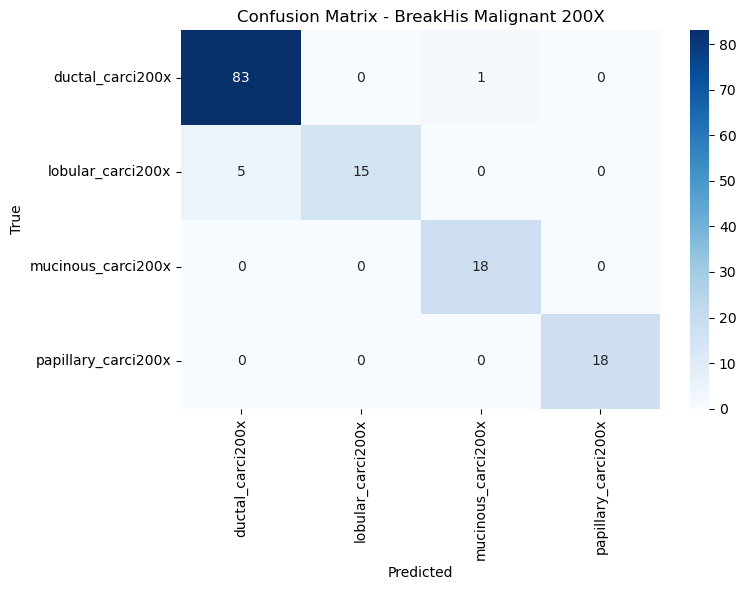

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BreakHis Malignant 200X')
plt.tight_layout()
plt.show()


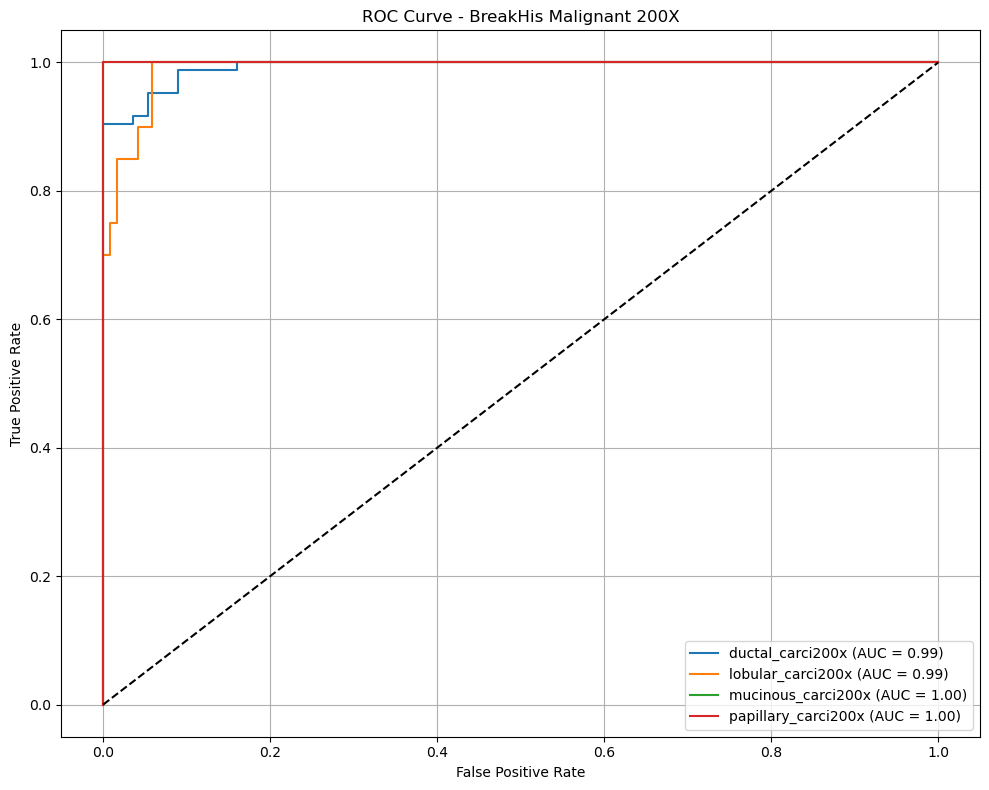

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get softmax probabilities
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# One-hot encode labels
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(4):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BreakHis Malignant 200X')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
torch.save(model.state_dict(), "hybrid_breakhis_malignant_200x.pth")